## Image superresolution


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab\ Notebooks/aml2024-students/Homeworks/HW6

/content/drive/MyDrive/Colab Notebooks/aml2024-students/Homeworks/HW6


In [3]:
!pip install piq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 78.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [4]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms as T
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import InterpolationMode
import math

import torch
from torch import nn
from torch import optim

from piq import ssim, SSIMLoss
from piq import gmsd, GMSDLoss
from piq import mdsi, MDSILoss

## Download the BSDS200 dataset

You may download it from https://cvnote.ddlee.cc/2019/09/22/image-super-resolution-datasets and move it manually to /content if following link does not work


# Defining the dataset class


*   Transform for data augmentation involves a random flip and a random translation




In [5]:
class TrainDataset(Dataset):
  #Args:
  #      image_dir (str): Train/Valid dataset address.
  #      upscale_factor (int): Image up scale factor.
  #      image_size (int): High resolution image size.

  def __init__(self, image_dir, upscale_factor,transforms=None):
    super(TrainDataset, self).__init__()

    self.transforms = transforms
    self.upscale_factor = upscale_factor

    # Preloading the data
    filelist = sorted(os.listdir(image_dir))
    image_file_names = [os.path.join(image_dir, image_file_name) for image_file_name in filelist]
    self.images = []
    for filename in image_file_names:
      self.images.append(read_image(filename)/255.)

  def __len__(self):
        return len(self.images)


  def __getitem__(self, batch_index: int):

    if self.transforms == None:
      hr_image = self.images[batch_index]
    else:
      hr_image = self.transforms(self.images[batch_index])
    image_size = hr_image.shape
    sx = int(image_size[-2]/self.upscale_factor)
    sy = int(image_size[-1]/self.upscale_factor)
    H2L = T.Resize((sx,sy),interpolation=InterpolationMode.BILINEAR,antialias=True)
    L2H = T.Resize((image_size[-2],image_size[-1]),interpolation=InterpolationMode.BILINEAR)

    lr_image = H2L(hr_image)
    hr_interpolated = L2H(lr_image)

    return hr_image, lr_image, hr_interpolated




# Defining the data loader: <font color=red> Task 4 </font>


Your <font color=red>**subtasks**</font> are the following

1.   Add additional data augmentations to the training data to see if you can improve performance. See torchvision.transforms for the available data augmentation transforms. You may also vary the randomcrop parameter to speed up the convergence or improve performance. Note that a higher patch size will result in slower runtime, but may offer improved performance.
2.   Repeat the experiments with upSamplingFatctor = 3



In [36]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# Upsampling factor; vary this and evaluate performance
upSamplingFactor = 3

#Data augmentations for training data; cropping to 128x128 patches to speed up training
augmentations = torch.nn.Sequential(
    T.RandomCrop(128),
    T.RandomHorizontalFlip(0.5),
    T.RandomVerticalFlip(0.5),
    T.ColorJitter(), # additional transform
    #T.RandomGrayscale(p=0.1) # additional transform
)

dataset = TrainDataset('./BSDS200',upSamplingFactor,augmentations)

# Deterministic test train split
test_idx = range(0,len(dataset),4)
train_idx = range(1,len(dataset),4)
for i in range(2,4):
  train_idx = np.append(train_idx,range(i,len(dataset),4))

datasets = {}
datasets['train'] = Subset(dataset, train_idx)

trainloader = DataLoader(datasets['train'],shuffle=True)

dataset = TrainDataset('./BSDS200',upSamplingFactor)
datasets['test'] = Subset(dataset, test_idx)
datasets['train'] = Subset(dataset, train_idx)

testloaderFull = DataLoader(datasets['test'],shuffle=False)
trainloaderFull = DataLoader(datasets['train'],shuffle=False)



# Display a random batch of training patches.

Since shuffle is true, running multiple times will display multiple images with random crops and flips, specified by the transform

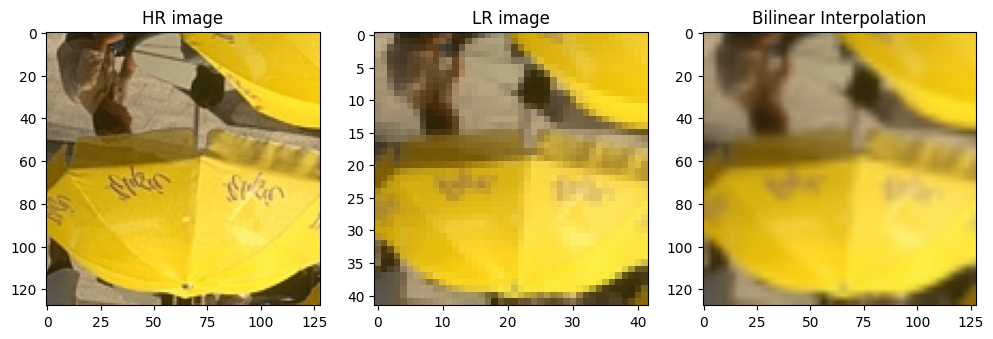

In [7]:
hr_image, lr_image, bilinear = next(iter(trainloader))
fig, ax = plt.subplots(1,3,figsize=(12,4))
s=ax[0].imshow(np.transpose(np.asarray(hr_image[0]),(1,2,0)))
s=ax[0].set_title('HR image')
s=ax[1].imshow(np.transpose(np.asarray(lr_image[0]),(1,2,0)))
s=ax[1].set_title('LR image')
s=ax[2].imshow(np.transpose(np.asarray(bilinear[0]),(1,2,0)))
s=ax[2].set_title('Bilinear Interpolation')


# SRCNN module

SRCNN consists of three layers


1.   A feature extraction layer with

*   An upsampling layer with upSamplingFactor
*   kernel size of 9 and nBaseChannels channels, and preserves the image size and RELU


2.   A mapping layer with kernel size of 5  and nBaseChannels channels and preserves the image size and RELU, which implements

$$y(x) = {\rm RELU}(H*x)$$

3. A reconstruction layer with kernel size of 5 without any activation

The weights are initialized to avoid the growth of coefficients, which will accelerate the training





In [8]:
class SRCNN(nn.Module):
    def __init__(self,nBaseChannels,upSamplingFactor) -> None:
      super(SRCNN, self).__init__()

      # Feature extraction layer.
      self.features = nn.Sequential(
        nn.Upsample(scale_factor=upSamplingFactor),
        nn.Conv2d(3, nBaseChannels, 9,1,4),
        nn.ReLU(True)
      )

      # Non-linear mapping layer.
      self.map = nn.Sequential(
        nn.Conv2d(nBaseChannels, nBaseChannels, 5,1,2),
        nn.ReLU(True),
      )

      # Reconstruction layer.
      self.reconstruction = nn.Conv2d(nBaseChannels, 3, 5,1,2)

      # Initialize model weights.
      self._initialize_weights()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
      out = self.features(x)
      out = self.map(out)
      out = self.reconstruction(out)
      return torch.clip(out,min=0,max=1)

    # The filter weight of each layer is a Gaussian distribution with zero mean and
    # standard deviation initialized by random extraction 0.001 (deviation is 0)
    def _initialize_weights(self) -> None:
      for module in self.modules():
          if isinstance(module, nn.Conv2d):
              torch.nn.init.xavier_uniform_(module.weight)
              #nn.init.normal_(module.weight.data, 0.0, math.sqrt(2 / (module.out_channels * module.weight.data[0][0].numel())))
              nn.init.zeros_(module.bias.data)

      nn.init.normal_(self.reconstruction.weight.data, 0.0, 0.001)
      nn.init.zeros_(self.reconstruction.bias.data)

# <font color=red> Task 1: SRResnet module </font>

You will construct a Resnet to improve the super-resolution performance. A resnet includes several residual blocks. A residual block implements

$$y(x) = x + {\rm RELU}(H*x),$$
where $H$ denotes a filterbank that preserves the channels and image size. You can use conv2 layer similar to the mapping layer in SRCNN above, while the forward method should implement the above equation.

Your <font color=red>**subtasks**</font> are the following

1.   Construct a residual block class with channels and kernel size as variables, and implements the above equation. You can use the same filter bank structure in the mapping layer of SRCNN


2.   Construct a SRResnet class with a feature and reconstruction layer similar to SRCNN above. The intermediate mapping layer should be replaced by five residual blocks

3. The weights of the resnet need to be initialized using Xavier initialization

In [66]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size):
    super(ResidualBlock, self).__init__()
    # YOUR CODE HERE
    self.block = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size,1,2),
        nn.ReLU(True),
    )

  def forward(self, x: torch.tensor) -> torch.tensor:
    # YOUR CODE HERE
    return x + (self.block(x))

class SRResnet(nn.Module):
  def __init__(self, nBaseChannels, upSamplingFactor)-> None:
    super(SRResnet, self).__init__()
    # YOUR CODE HERE

    # Feature extraction layer.
    self.features = nn.Sequential(
        nn.Upsample(scale_factor=upSamplingFactor),
        nn.Conv2d(3, nBaseChannels, 9,1,4),
        nn.ReLU(True)
    )

    # Non-linear mapping layer.
    self.map = nn.Sequential(
        # 5 Residual blocks
        ResidualBlock(nBaseChannels, nBaseChannels, 5),
        ResidualBlock(nBaseChannels, nBaseChannels, 5),
        ResidualBlock(nBaseChannels, nBaseChannels, 5),
        ResidualBlock(nBaseChannels, nBaseChannels, 5),
        ResidualBlock(nBaseChannels, nBaseChannels, 5),
    )

    # Reconstruction layer.
    self.reconstruction = nn.Conv2d(nBaseChannels, 3, 5,1,3)

    # Initialize model weights.
    self._initialize_weights()

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # YOUR CODE HERE
    out = self.features(x)
    out = self.map(out)
    out = self.reconstruction(out)
    return torch.clip(out,min=0,max=1)

  # The filter weight of each layer is a Gaussian distribution with zero mean and
  # standard deviation initialized by random extraction 0.001 (deviation is 0)
  def _initialize_weights(self) -> None:
    for module in self.modules():
      if isinstance(module, nn.Conv2d):
          torch.nn.init.xavier_normal_(module.weight)
          nn.init.zeros_(module.bias.data)

    nn.init.normal_(self.reconstruction.weight.data, 0.0, 0.001)
    nn.init.zeros_(self.reconstruction.bias.data)

## <font color=red>Task 2: Replace SRCNN using SRResnet and train </font>

If task 1 is properly implemented, this step should be straight forward. Your <font color=red>**subtasks**</font> are the following



1.   Change the optimizers and the hyperparameters to see if you can improve performance of final testing error
2.  Experiment with weight decay and early stopping if you can improve performance
3. Replace the l1 error loss used below with MSE and SSIM losses. Note that a variety of differentiable loss functions are available at https://piq.readthedocs.io/en/latest/. Feel free to experiment with them to improve image quality (optional)





In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#Net = SRCNN(32,upSamplingFactor=upSamplingFactor).to(device)
Net = SRResnet(32,upSamplingFactor=upSamplingFactor).to(device)


#lossfn = torch.nn.L1Loss(reduction='mean')
lossfn = torch.nn.MSELoss()
#lossfn = SSIMLoss()

optimizer = optim.Adam(Net.parameters(), lr=0.00001)

for epoch in range(30): # reduced # of epochs because it was taking too long
  epochloss = 0
  for hr_image, lr_image, hr_interpolated in trainloader:
    out = Net(lr_image.to(device))
    cost =lossfn(out,hr_image.to(device))
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    epochloss += cost
  if np.mod(epoch,5)==0:
    print(epochloss.item()/dataset.__len__())

0.04432854652404785
0.00876653790473938
0.005842029452323914
0.004372231662273407
0.004150601923465729
0.004304490089416504


## <font color=red>Task 3: Quantitative evaluation


Write a script to evaluate the above four different error metrics

In [15]:
# YOUR CODE HERE
loss_functions = [torch.nn.L1Loss(reduction='mean'), torch.nn.MSELoss(), SSIMLoss()]
loss_function_names = ["L1", "MSE", "SSIM"]

for i in range(3):
  lossfn = loss_functions[i]
  print(loss_function_names[i] + " losses:")
  for epoch in range(20): # reduced epochs to save time
    epochloss = 0
    for hr_image, lr_image, hr_interpolated in trainloader:
      out = Net(lr_image.to(device))
      cost =lossfn(out,hr_image.to(device))
      optimizer.zero_grad()
      cost.backward()
      optimizer.step()
      epochloss += cost
    if np.mod(epoch,5)==0:
      print(epochloss.item()/dataset.__len__())


L1 losses:
0.0369648289680481
0.0329714560508728
0.03350275754928589
0.03489298105239868
MSE losses:
0.003841639757156372
0.00350454568862915
0.003576939105987549
0.0032845243811607363
SSIM losses:
0.22483236312866212
0.20876659393310548
0.2065562438964844
0.21286222457885742


# Visual evaluation on test data

Compare the image quality for the four different error metrics

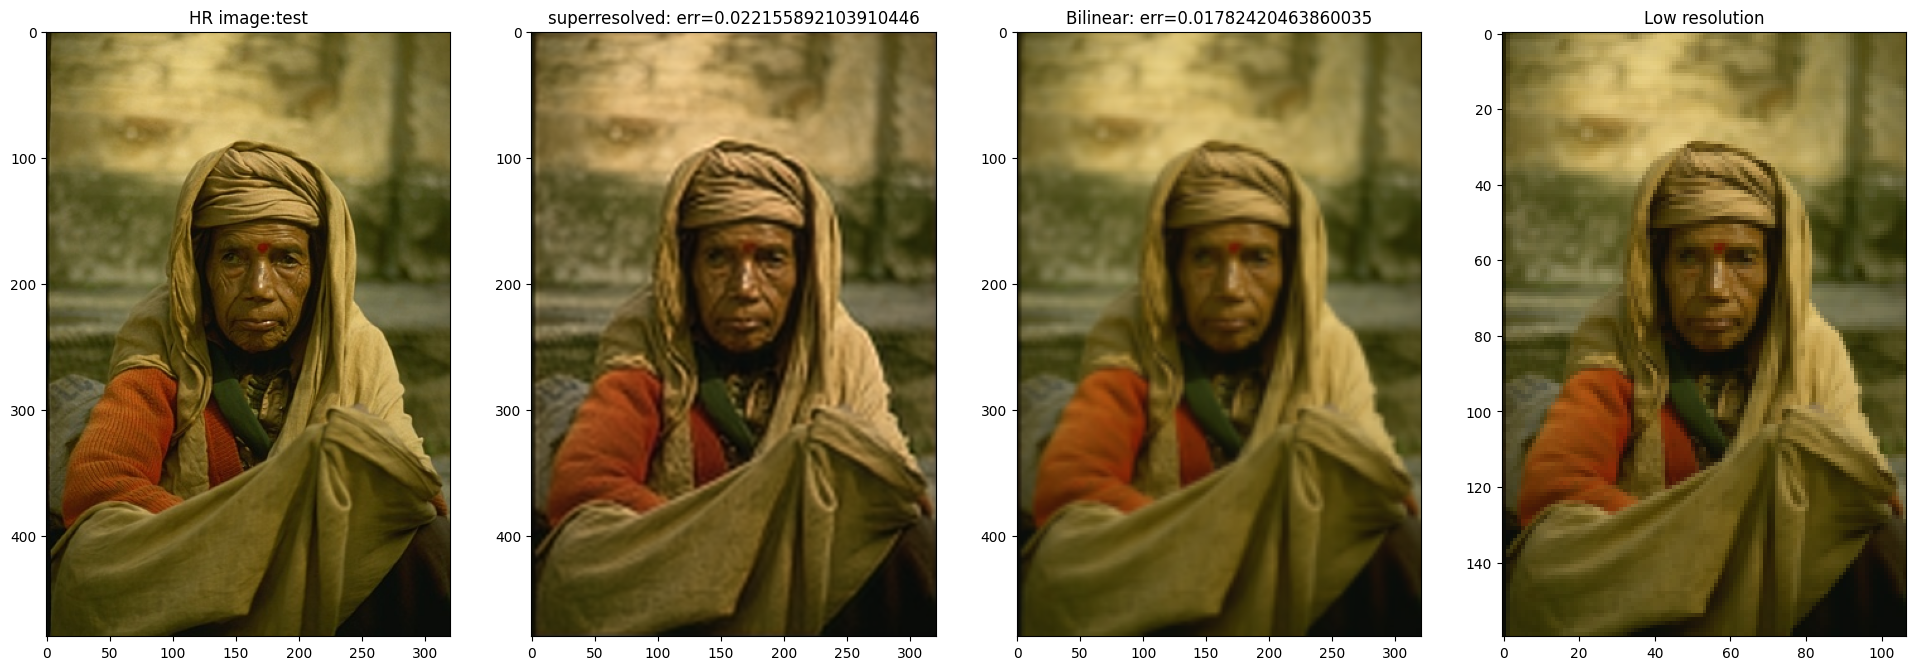

In [75]:
hr_image, a, b = datasets['test'].__getitem__(18)
hr_image = hr_image.unsqueeze(0)

# Image size may not be divisible by upSamplingFactor; resizing the original image
imsize = list(hr_image.shape[-2:])
imsize[0] = upSamplingFactor*int(imsize[0]/upSamplingFactor)
imsize[1] = upSamplingFactor*int(imsize[1]/upSamplingFactor)

Crop = T.CenterCrop(imsize)
hr_image = Crop(hr_image)
sx = int(imsize[0]/upSamplingFactor)
sy = int(imsize[1]/upSamplingFactor)
H2L = T.Resize((sx,sy),interpolation=InterpolationMode.BILINEAR,antialias=True)
lr_image = H2L(hr_image)
L2H = T.Resize((imsize[0],imsize[1]),interpolation=InterpolationMode.BILINEAR)
bilinear = L2H(lr_image)

# Evaluation

out = Net(lr_image.to(device)).detach().cpu()
out = Crop(out)
fig, ax = plt.subplots(1,4,figsize=(24,8))
s=ax[0].imshow(np.transpose(np.asarray(hr_image[0]),(1,2,0)))
s=ax[0].set_title('HR image:test')
s=ax[1].imshow(np.transpose(np.asarray(out[0]),(1,2,0)))
sz = out.shape
lossfn = torch.nn.L1Loss(reduction='mean') # reassign the MSE loss function
cost = lossfn(out,hr_image[:,:,:sz[2],:sz[3]]).item()

img_size = out.shape
s=ax[1].set_title('superresolved: err='+str(cost))

s=ax[2].imshow(np.transpose(np.asarray(bilinear[0]),(1,2,0)))
cost = lossfn(bilinear,hr_image).item()

s=ax[2].set_title('Bilinear: err='+str(cost))

s=ax[3].imshow(np.transpose(np.asarray(lr_image[0]),(1,2,0)))
s=ax[3].set_title('Low resolution')



# Try on training data.

If the approach works well on training data and poorly on test data, it indicates overfitting

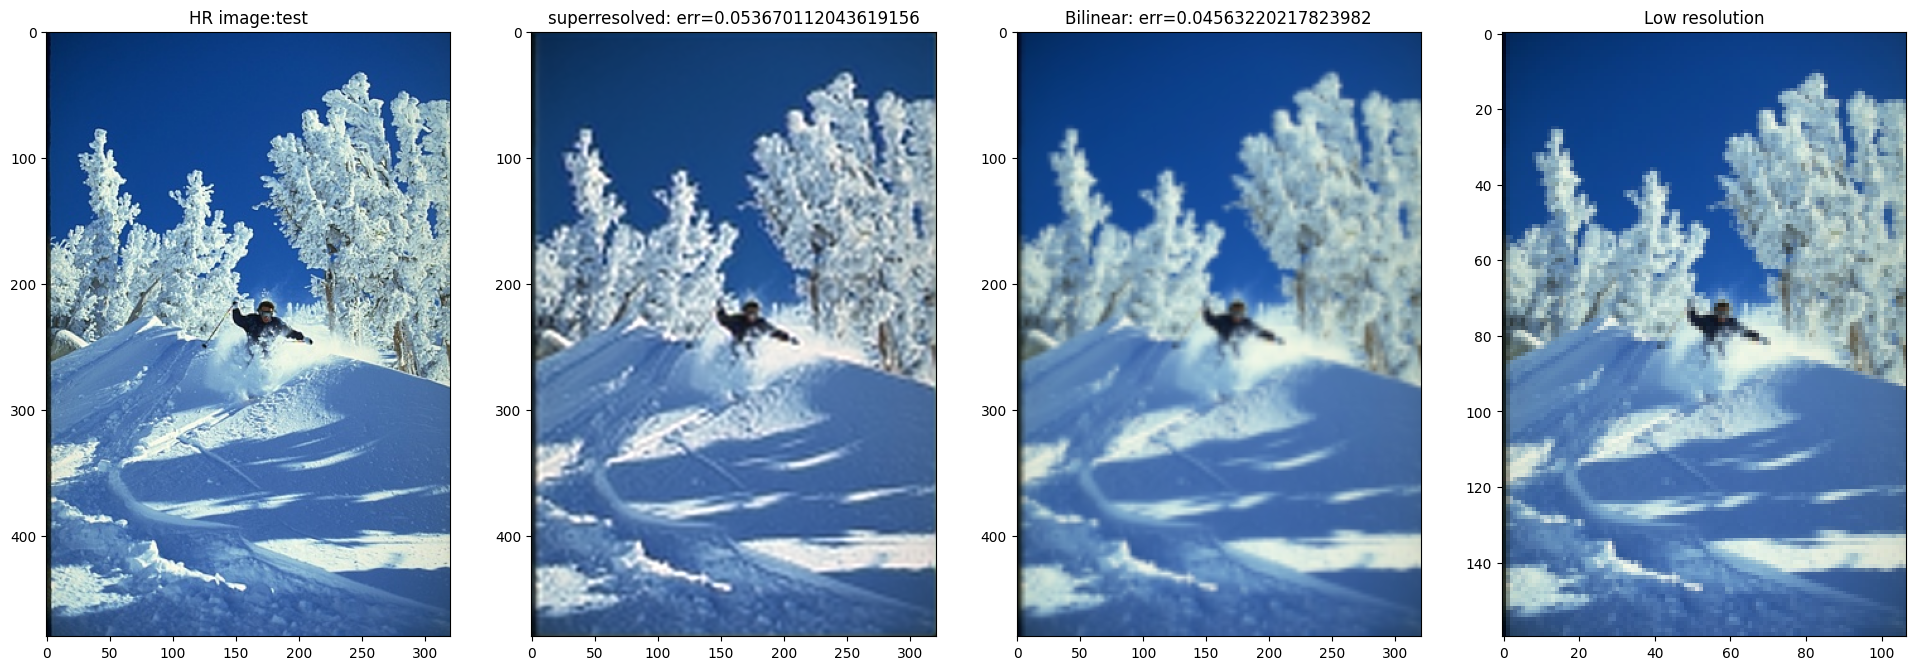

In [76]:
hr_image, lr_image, bilinear = datasets['train'].__getitem__(23)
hr_image = hr_image.unsqueeze(0)

imsize = list(hr_image.shape[-2:])

imsize[0] = upSamplingFactor*int(imsize[0]/upSamplingFactor)
imsize[1] = upSamplingFactor*int(imsize[1]/upSamplingFactor)

Crop = T.CenterCrop(imsize)
hr_image = Crop(hr_image)
sx = int(imsize[0]/upSamplingFactor)
sy = int(imsize[1]/upSamplingFactor)
H2L = T.Resize((sx,sy),interpolation=InterpolationMode.BILINEAR,antialias=True)
lr_image = H2L(hr_image)
L2H = T.Resize((imsize[0],imsize[1]),interpolation=InterpolationMode.BILINEAR)
bilinear = L2H(lr_image)

out = Net(lr_image.to(device)).detach().cpu()
out = Crop(out)
fig, ax = plt.subplots(1,4,figsize=(24,8))
s=ax[0].imshow(np.transpose(np.asarray(hr_image[0]),(1,2,0)))
s=ax[0].set_title('HR image:test')
s=ax[1].imshow(np.transpose(np.asarray(out[0]),(1,2,0)))
sz = out.shape
cost = lossfn(out,hr_image[:,:,:sz[2],:sz[3]]).item()

img_size = out.shape
s=ax[1].set_title('superresolved: err='+str(cost))

s=ax[2].imshow(np.transpose(np.asarray(bilinear[0]),(1,2,0)))
cost = lossfn(bilinear,hr_image).item()

s=ax[2].set_title('Bilinear: err='+str(cost))

s=ax[3].imshow(np.transpose(np.asarray(lr_image[0]),(1,2,0)))
s=ax[3].set_title('Low resolution')